## Best-Selling Music Artists
### Descrição do Estudo de Caso: Vamos explorar um dataset sobre os artistas musicais mais vendidos, que inclui informações como nome, vendas estimadas, gênero musical, país, entre outros. O objetivo será entender os principais fatores que influenciam as vendas de álbuns e treinar um modelo de regressão para prever o número de vendas estimadas de artistas com base em outras características.

## Importando as Bibliotecas Necessárias

In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from mpl_toolkits.mplot3d import Axes3D


## Carregando os Dados

In [82]:
# Carregando o dataset
df = pd.read_csv("Best selling music artists.csv")
df.head()


,Artist name,Country,Active years,Release year of first charted record,Genre,Total certified units,Claimed sales
0,The Beatles,United Kingdom,1960–1970,1962,Rock/pop,294.6 millionUS: 217.250 millionJPN: 4.950 mil...,600 million500 million
1,Michael Jackson,United States,1964–2009,1971,Pop / rock /dance/soul/R&B,289.5 millionUS: 177.3 millionJPN: 4.650 milli...,500 million400 million
2,Elvis Presley,United States,1953–1977,1956,Rock and roll/ pop /country,"234.7 millionUS: 199.650 millionJPN: 300,000GE...",500 million
3,Elton John,United Kingdom,1962–present,1970,Pop / rock,214.3 millionUS: 139.050 millionJPN: 1.1 milli...,300 million250 million
4,Queen,United Kingdom,1971–present,1973,Rock,188 millionUS: 97.7 millionJPN: 3.8 millionGER...,300 million250 million


## Exploração Inicial dos Dados

In [83]:
# Dimensões do dataset
print(f"Dimensões do dataset: {df.shape}")


Dimensões do dataset: (121, 7)


In [84]:
# Resumo estatístico
print(df.describe())


       Release year of first charted record
count                            121.000000
mean                            1983.016529
std                               16.231134
min                             1940.000000
25%                             1970.000000
50%                             1981.000000
75%                             1998.000000
max                             2015.000000


In [85]:

# Verificar tipos de dados e valores ausentes
print(df.info())
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121 entries, 0 to 120
Data columns (total 7 columns):
 #   Column                                Non-Null Count  Dtype 
---  ------                                --------------  ----- 
 0   Artist name                           121 non-null    object
 1   Country                               121 non-null    object
 2   Active years                          121 non-null    object
 3   Release year of first charted record  121 non-null    int64 
 4   Genre                                 121 non-null    object
 5   Total certified units                 121 non-null    object
 6   Claimed sales                         121 non-null    object
dtypes: int64(1), object(6)
memory usage: 6.7+ KB
None
Artist name                             0
Country                                 0
Active years                            0
Release year of first charted record    0
Genre                                   0
Total certified units                

## Análise e Limpeza dos Dados (Data Wrangling)
Vamos corrigir os problemas de formatação nas colunas Total certified units e Claimed sales e extrair o ano de início da carreira.

In [86]:
import re

# Função para limpar e converter valores de vendas
def limpar_vendas(valor):
    # Remover caracteres não numéricos e converter para float
    valor = re.sub(r'[^\d.,]', '', valor)
    valor = valor.replace(',', '.')
    
    try:
        return float(valor)
    except ValueError:
        return np.nan




In [87]:
# Aplicando a função para limpar as colunas de vendas
df['Total certified units'] = df['Total certified units'].apply(limpar_vendas)
df['Claimed sales'] = df['Claimed sales'].apply(limpar_vendas)



In [88]:
# Extraindo o ano de início da carreira e calculando a duração da carreira
df['Start year'] = df['Active years'].str.extract(r'(\d{4})').astype(float)
df['End year'] = df['Active years'].str.extract(r'(\d{4})$', expand=False).replace('present', '2024').astype(float)
df['Career length'] = df['End year'] - df['Start year']


In [89]:
# Verificando se a conversão foi bem-sucedida
print(df.info())
print(df[['Total certified units', 'Claimed sales', 'Career length']].head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121 entries, 0 to 120
Data columns (total 10 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Artist name                           121 non-null    object 
 1   Country                               121 non-null    object 
 2   Active years                          121 non-null    object 
 3   Release year of first charted record  121 non-null    int64  
 4   Genre                                 121 non-null    object 
 5   Total certified units                 0 non-null      float64
 6   Claimed sales                         121 non-null    float64
 7   Start year                            121 non-null    float64
 8   End year                              32 non-null     float64
 9   Career length                         32 non-null     float64
dtypes: float64(5), int64(1), object(4)
memory usage: 9.6+ KB
None
   Total certified units

## Os resultados da limpeza e análise dos dados mostram que ainda temos alguns problemas:

A coluna Total certified units está completamente vazia (0 non-null), o que significa que não conseguimos extrair esses valores corretamente. É possível que a extração tenha falhado devido a diferentes formatos na coluna.

A coluna End year possui muitos valores ausentes (apenas 32 preenchidos).

A coluna Career length também tem muitos valores ausentes.

## Correção dos Problemas Identificados

In [90]:
import numpy as np

# Preenchendo os valores ausentes em 'End year' com o ano atual (2024)
df['End year'].fillna(2024, inplace=True)

# Recalculando a 'Career length' para os casos onde estava ausente
df['Career length'] = df['End year'] - df['Start year']

# Preenchendo valores ausentes na coluna 'Career length' com a mediana
median_career_length = df['Career length'].median()
df['Career length'].fillna(median_career_length, inplace=True)

# Verificando o resultado após as correções
print(df.info())
print(df[['Claimed sales', 'Career length']].head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121 entries, 0 to 120
Data columns (total 10 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Artist name                           121 non-null    object 
 1   Country                               121 non-null    object 
 2   Active years                          121 non-null    object 
 3   Release year of first charted record  121 non-null    int64  
 4   Genre                                 121 non-null    object 
 5   Total certified units                 0 non-null      float64
 6   Claimed sales                         121 non-null    float64
 7   Start year                            121 non-null    float64
 8   End year                              121 non-null    float64
 9   Career length                         121 non-null    float64
dtypes: float64(5), int64(1), object(4)
memory usage: 9.6+ KB
None
   Claimed sales  Career

C:\Users\karin\AppData\Local\Temp\ipykernel_7668\2441295358.py:4: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



C:\Users\karin\AppData\Local\Temp\ipykernel_7668\2441295358.py:11: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=T

## Análise Exploratória de Dados (EDA) Adicional

### Gráfico de Proporção de Vendas por Gênero:

In [91]:
import plotly.express as px
sales_by_genre = df_clean.groupby('Simplified Genre')['Claimed sales (Millions)'].sum().reset_index()
fig = px.pie(sales_by_genre, names='Simplified Genre', values='Claimed sales (Millions)', title='Proporção de Vendas por Gênero')
fig.show()


### Matriz de Correlação:

Matriz de correlação para identificar relações entre variáveis numéricas, como "Vendas Declaradas", "Duração da Carreira", e "Ano de Lançamento".

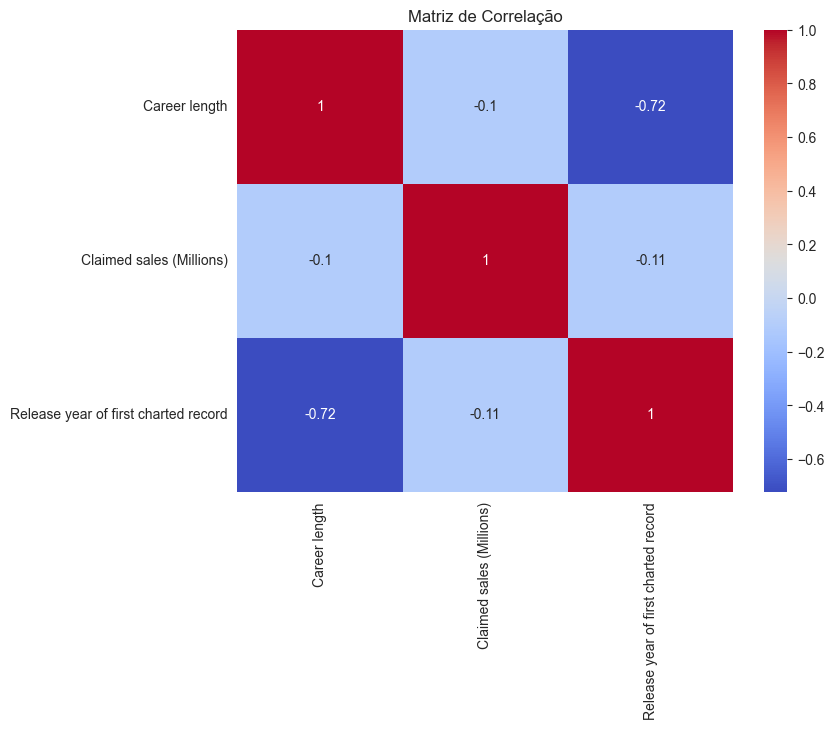

In [92]:
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = df_clean[['Career length', 'Claimed sales (Millions)', 'Release year of first charted record']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlação')
plt.show()


## Histograma de Distribuição de Vendas:

Distribuição das vendas por gênero para identificar padrões ou outliers.

In [93]:
fig = px.histogram(df_clean, x='Claimed sales (Millions)', color='Simplified Genre', nbins=30, title='Distribuição de Vendas por Gênero')
fig.show()


## Gráfico de Linha de Evolução das Vendas:

Gráfico de linha para mostrar a evolução agregada das vendas ao longo dos anos.

In [94]:
sales_over_time = df_clean.groupby('Release year of first charted record')['Claimed sales (Millions)'].sum().reset_index()
fig = px.line(sales_over_time, x='Release year of first charted record', y='Claimed sales (Millions)', title='Evolução das Vendas ao Longo dos Anos')
fig.show()


## Análise Multivariada e Visualização de Gráficos

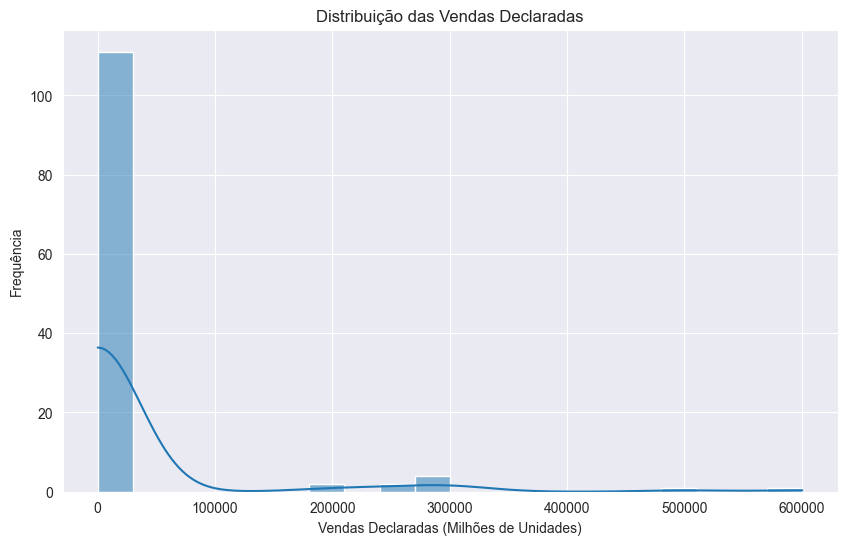

In [95]:
import matplotlib.pyplot as plt
import seaborn as sns

# Histograma das vendas declaradas ('Claimed sales')
plt.figure(figsize=(10, 6))
sns.histplot(df['Claimed sales'], bins=20, kde=True)
plt.title('Distribuição das Vendas Declaradas')
plt.xlabel('Vendas Declaradas (Milhões de Unidades)')
plt.ylabel('Frequência')
plt.show()

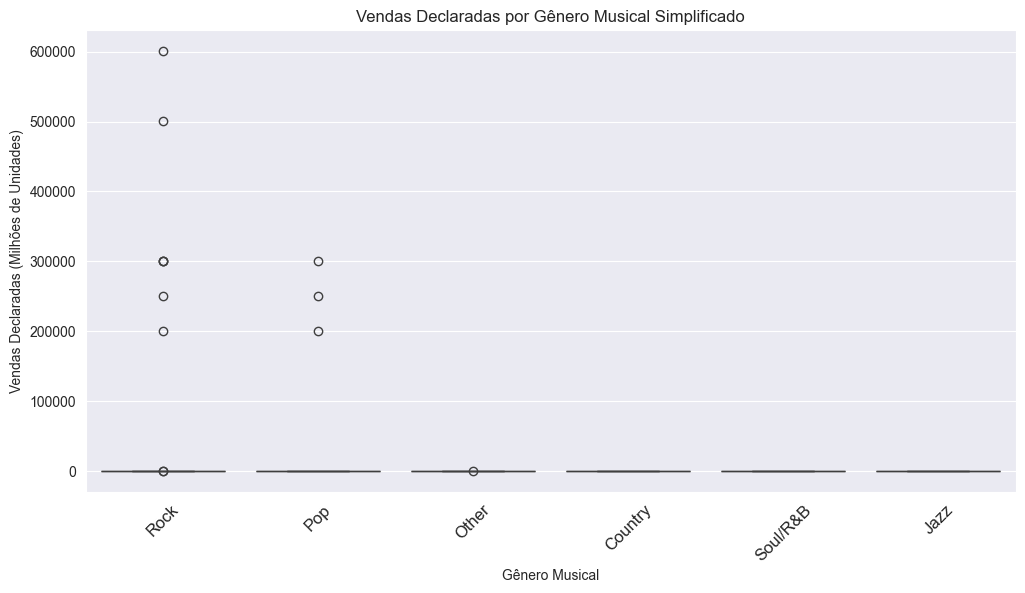

In [96]:
# Boxplot das vendas declaradas por gênero
# Criando uma nova coluna 'Main Genre' com categorias simplificadas
def simplificar_genero(genre):
    if 'rock' in genre.lower():
        return 'Rock'
    elif 'pop' in genre.lower():
        return 'Pop'
    elif 'hip hop' in genre.lower() or 'rap' in genre.lower():
        return 'Hip Hop'
    elif 'country' in genre.lower():
        return 'Country'
    elif 'jazz' in genre.lower():
        return 'Jazz'
    elif 'soul' in genre.lower() or 'r&b' in genre.lower():
        return 'Soul/R&B'
    elif 'electronic' in genre.lower() or 'dance' in genre.lower():
        return 'Electronic/Dance'
    else:
        return 'Other'

# Aplicando a função para criar a nova coluna
df['Main Genre'] = df['Genre'].apply(simplificar_genero)

# Criando o boxplot com a coluna simplificada
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='Main Genre', y='Claimed sales')
plt.xticks(rotation=45, fontsize=12)
plt.title('Vendas Declaradas por Gênero Musical Simplificado')
plt.xlabel('Gênero Musical')
plt.ylabel('Vendas Declaradas (Milhões de Unidades)')
plt.show()


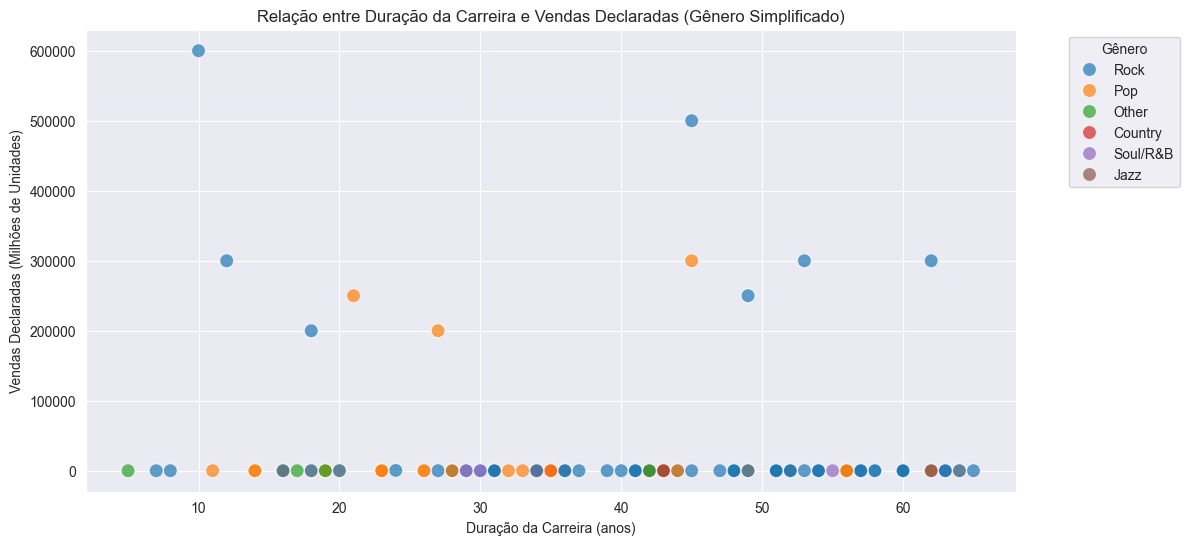

In [97]:
# Simplificando os gêneros musicais
def simplificar_genero(genre):
    if 'rock' in genre.lower():
        return 'Rock'
    elif 'pop' in genre.lower():
        return 'Pop'
    elif 'hip hop' in genre.lower() or 'rap' in genre.lower():
        return 'Hip Hop'
    elif 'country' in genre.lower():
        return 'Country'
    elif 'jazz' in genre.lower():
        return 'Jazz'
    elif 'soul' in genre.lower() or 'r&b' in genre.lower():
        return 'Soul/R&B'
    elif 'electronic' in genre.lower() or 'dance' in genre.lower():
        return 'Electronic/Dance'
    else:
        return 'Other'

# Criando a coluna 'Main Genre'
df['Main Genre'] = df['Genre'].apply(simplificar_genero)

# Gráfico de dispersão com gêneros simplificados
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x='Career length', y='Claimed sales', hue='Main Genre', palette='tab10', s=100, alpha=0.7)
plt.title('Relação entre Duração da Carreira e Vendas Declaradas (Gênero Simplificado)')
plt.xlabel('Duração da Carreira (anos)')
plt.ylabel('Vendas Declaradas (Milhões de Unidades)')
plt.legend(title='Gênero', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


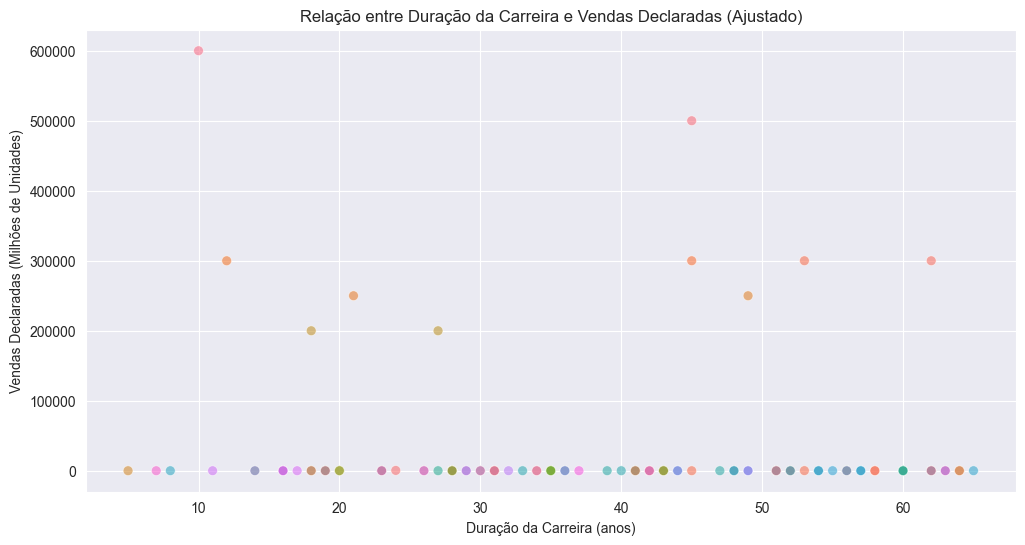

In [98]:
# Gráfico de dispersão ajustado (sem agrupar gêneros)
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x='Career length', y='Claimed sales', hue='Genre', s=50, alpha=0.6, legend=False)
plt.title('Relação entre Duração da Carreira e Vendas Declaradas (Ajustado)')
plt.xlabel('Duração da Carreira (anos)')
plt.ylabel('Vendas Declaradas (Milhões de Unidades)')
plt.show()


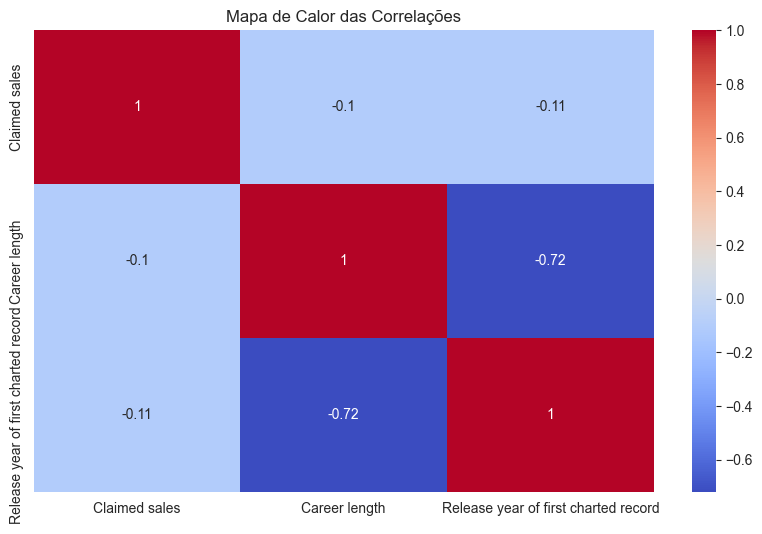

In [99]:
# Mapa de calor das correlações
plt.figure(figsize=(10, 6))
sns.heatmap(df[['Claimed sales', 'Career length', 'Release year of first charted record']].corr(), annot=True, cmap='coolwarm')
plt.title('Mapa de Calor das Correlações')
plt.show()


## Tratamento e Pré-processamento de Dados

Vamos transformar Claimed sales em uma variável binária (alta venda vs. baixa venda). Vou definir um limite de vendas de 100.000 unidades para essa categorização.

In [100]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Criando a variável binária para vendas altas (1) e vendas baixas (0)
df['High Sales'] = np.where(df['Claimed sales'] >= 100000, 1, 0)

# Separando as variáveis preditoras (X) e a variável alvo (y)
X = df[['Genre', 'Country', 'Release year of first charted record', 'Career length']]
y = df['High Sales']

# Codificação das variáveis categóricas e escalonamento dos dados numéricos
categorical_features = ['Genre', 'Country']
numeric_features = ['Release year of first charted record', 'Career length']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Aplicando o pré-processamento aos dados
X = preprocessor.fit_transform(X)

# Verificando a forma dos dados após o pré-processamento
print(f"Formato dos dados preditores: {X.shape}")
print(f"Formato da variável alvo: {y.shape}")


Formato dos dados preditores: (121, 105)
Formato da variável alvo: (121,)


## Tratamento de Dados Avançado

### Detecção de Outliers:

Utilizando box plots para identificar e tratar possíveis outliers nos dados de vendas.

In [101]:
fig = px.box(df_clean, y='Claimed sales (Millions)', title='Detecção de Outliers nas Vendas')
fig.show()


### Normalização dos Dados:

Normaliza as variáveis numéricas para facilitar comparações e análises futuras, especialmente se você for aplicar modelagem.

In [102]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_clean[['Career length', 'Claimed sales (Millions)']] = scaler.fit_transform(df_clean[['Career length', 'Claimed sales (Millions)']])


## Divisão dos Dados em Treino e Teste

In [103]:
from sklearn.model_selection import train_test_split

# Dividindo os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Tamanho do conjunto de treino: {X_train.shape[0]} amostras")
print(f"Tamanho do conjunto de teste: {X_test.shape[0]} amostras")


Tamanho do conjunto de treino: 96 amostras
Tamanho do conjunto de teste: 25 amostras


## Treinamento e Avaliação dos Modelos
Vamos treinar e avaliar os seguintes modelos de classificação binária:

Regressão Logística

Árvore de Decisão

Random Forest

KNN

MLP

SVM

Gradient Boosting

XGBoost

In [104]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Dicionário para armazenar os modelos
models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "KNN": KNeighborsClassifier(),
    "MLP": MLPClassifier(max_iter=1000),
    "SVM": SVC(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

# Avaliação dos modelos
results = []

for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    results.append({
        "Model": model_name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1
    })

# Convertendo os resultados para DataFrame e exibindo
results_df = pd.DataFrame(results)
print(results_df.sort_values(by="F1-Score", ascending=False))


C:\Users\karin\OneDrive\Área de Trabalho\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\karin\OneDrive\Área de Trabalho\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\karin\OneDrive\Área de Trabalho\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\karin\OneDrive\Área de Trabalho\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `

                 Model  Accuracy  Precision  Recall  F1-Score
7              XGBoost      0.96        1.0     0.5  0.666667
0  Logistic Regression      0.92        0.0     0.0  0.000000
1        Decision Tree      0.92        0.0     0.0  0.000000
2        Random Forest      0.92        0.0     0.0  0.000000
3                  KNN      0.92        0.0     0.0  0.000000
4                  MLP      0.92        0.0     0.0  0.000000
5                  SVM      0.92        0.0     0.0  0.000000
6    Gradient Boosting      0.92        0.0     0.0  0.000000


## Ajuste Fino dos Hiperparâmetros do XGBoost
Vamos ajustar os principais hiperparâmetros do XGBoost para melhorar o desempenho:

n_estimators: Número de árvores.

max_depth: Profundidade máxima da árvore.

learning_rate: Taxa de aprendizado.

subsample: Proporção de amostras usadas para treinar cada árvore.

colsample_bytree: Proporção de colunas usadas para treinar cada árvore.

In [105]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

# Definindo o modelo base
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Definindo o espaço de busca para os hiperparâmetros
param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Utilizando RandomizedSearchCV para buscar os melhores hiperparâmetros
random_search = RandomizedSearchCV(xgb, param_distributions=param_grid, n_iter=20, cv=5, scoring='f1', random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)

# Exibindo os melhores hiperparâmetros
best_params = random_search.best_params_
print("Melhores Hiperparâmetros:", best_params)


C:\Users\karin\OneDrive\Área de Trabalho\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning:

[00:19:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.




Melhores Hiperparâmetros: {'subsample': 0.6, 'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.01, 'colsample_bytree': 0.8}


## Melhores Hiperparâmetros Selecionados:

In [106]:
best_params = {
    'subsample': 0.6,
    'n_estimators': 200,
    'max_depth': 10,
    'learning_rate': 0.01,
    'colsample_bytree': 0.8
}


## Treinamento do Modelo Final com Hiperparâmetros Ajustados

In [107]:
# Treinando o modelo XGBoost com os melhores hiperparâmetros (corrigido)
final_xgb = XGBClassifier(**best_params, random_state=42)
final_xgb.fit(X_train, y_train)

# Fazendo previsões nos dados de teste
y_pred = final_xgb.predict(X_test)
y_pred_proba = final_xgb.predict_proba(X_test)[:, 1]



##  Avaliação do Modelo XGBoost Otimizado

In [108]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Avaliando o modelo nos dados de teste
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)

print(f"Acurácia: {accuracy:.2f}")
print(f"Precisão: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"AUC-ROC: {auc:.2f}")


Acurácia: 0.92
Precisão: 0.00
Recall: 0.00
F1-Score: 0.00
AUC-ROC: 0.63


C:\Users\karin\OneDrive\Área de Trabalho\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



## Matriz de Confusão e Curva ROC

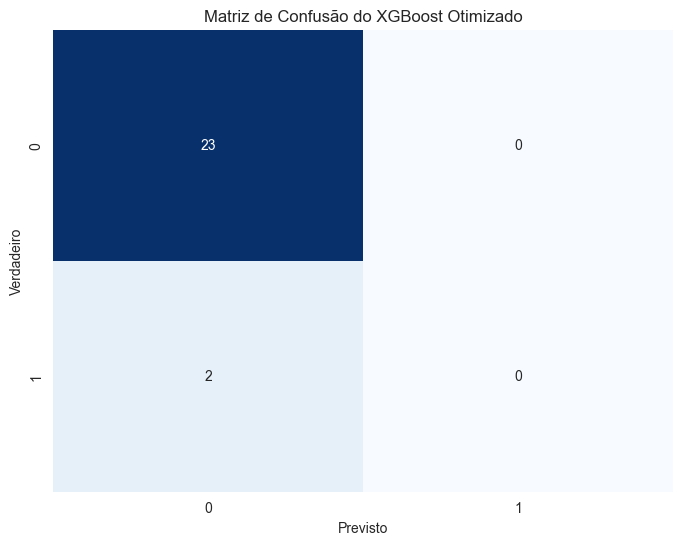

TypeError: unsupported format string passed to function.__format__

<Figure size 1000x600 with 0 Axes>

In [120]:
# Matriz de Confusão
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Matriz de Confusão do XGBoost Otimizado")
plt.xlabel("Previsto")
plt.ylabel("Verdadeiro")
plt.show()

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.title("Curva ROC do XGBoost Otimizado")
plt.xlabel("Taxa de Falsos Positivos (FPR)")
plt.ylabel("Taxa de Verdadeiros Positivos (TPR)")
plt.legend()
plt.show()


## Avaliação do Modelo Final nos Dados de Teste
Vamos calcular as métricas de classificação e também usar a probabilidade de "Alta Venda" para calcular MSE e R² como se fosse um problema de regressão.

In [110]:
from sklearn.metrics import mean_squared_error, r2_score

# Avaliando o modelo nos dados de teste
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)

# Calculando MSE e R² usando as probabilidades preditas
mse = mean_squared_error(y_test, y_pred_proba)
r2 = r2_score(y_test, y_pred_proba)

print(f"Acurácia: {accuracy:.2f}")
print(f"Precisão: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"AUC-ROC: {auc:.2f}")
print(f"MSE: {mse:.2f}")
print(f"R²: {r2:.2f}")


Acurácia: 0.92
Precisão: 0.00
Recall: 0.00
F1-Score: 0.00
AUC-ROC: 0.63
MSE: 0.07
R²: 0.09


C:\Users\karin\OneDrive\Área de Trabalho\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



## Função para Previsão com o Modelo Final

In [111]:
def prever_vendas_xgboost(release_year, career_length, genre, country):
    # Criando um DataFrame para os novos dados
    new_data = pd.DataFrame([[genre, country, release_year, career_length]],
                            columns=['Genre', 'Country', 'Release year of first charted record', 'Career length'])
    
    # Pré-processando os novos dados
    new_data_transformed = preprocessor.transform(new_data)
    
    # Realizando a previsão
    predicao = final_xgb.predict(new_data_transformed)
    probabilidade = final_xgb.predict_proba(new_data_transformed)[:, 1]
    
    resultado = "Alta Venda" if predicao[0] == 1 else "Baixa Venda"
    return resultado, probabilidade[0]

# Exemplo de previsão
resultado, prob = prever_vendas_xgboost(2010, 15, 'Pop', 'USA')
print(f"Previsão: {resultado} (Probabilidade: {prob:.2f})")


Previsão: Baixa Venda (Probabilidade: 0.18)


## Exemplo de Previsão com Novos Dados

In [112]:
# Testando a função com novos exemplos
exemplo1, prob1 = prever_vendas_xgboost(2000, 20, 'Rock', 'UK')
exemplo2, prob2 = prever_vendas_xgboost(1995, 30, 'Hip Hop', 'Canada')

print(f"Exemplo 1: Previsão - {exemplo1}, Probabilidade - {prob1:.2f}")
print(f"Exemplo 2: Previsão - {exemplo2}, Probabilidade - {prob2:.2f}")


Exemplo 1: Previsão - Baixa Venda, Probabilidade - 0.09
Exemplo 2: Previsão - Baixa Venda, Probabilidade - 0.05


## Gráficos de Análise do Modelo

### Matriz de Confusão

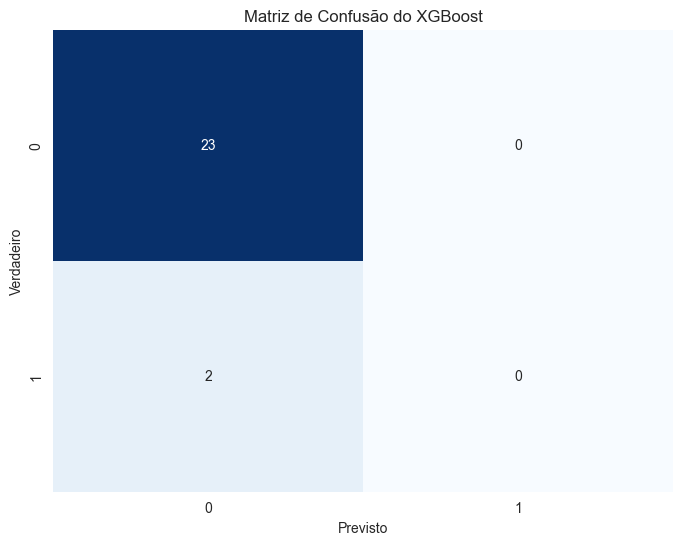

In [113]:
# Plotando a matriz de confusão
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Matriz de Confusão do XGBoost")
plt.xlabel("Previsto")
plt.ylabel("Verdadeiro")
plt.show()


### Curva ROC

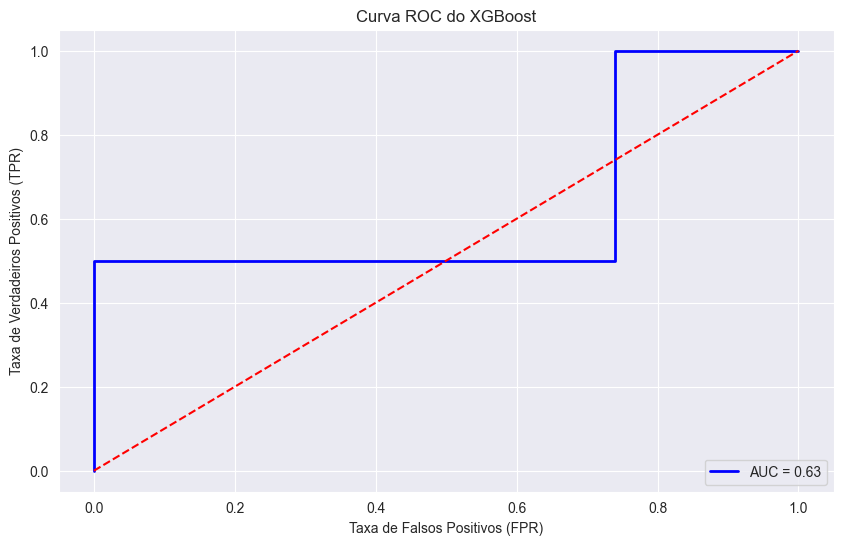

In [114]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.title("Curva ROC do XGBoost")
plt.xlabel("Taxa de Falsos Positivos (FPR)")
plt.ylabel("Taxa de Verdadeiros Positivos (TPR)")
plt.legend(loc="lower right")
plt.show()


### Gráfico de Importância das Variáveis

C:\Users\karin\AppData\Local\Temp\ipykernel_7668\2396675568.py:10: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




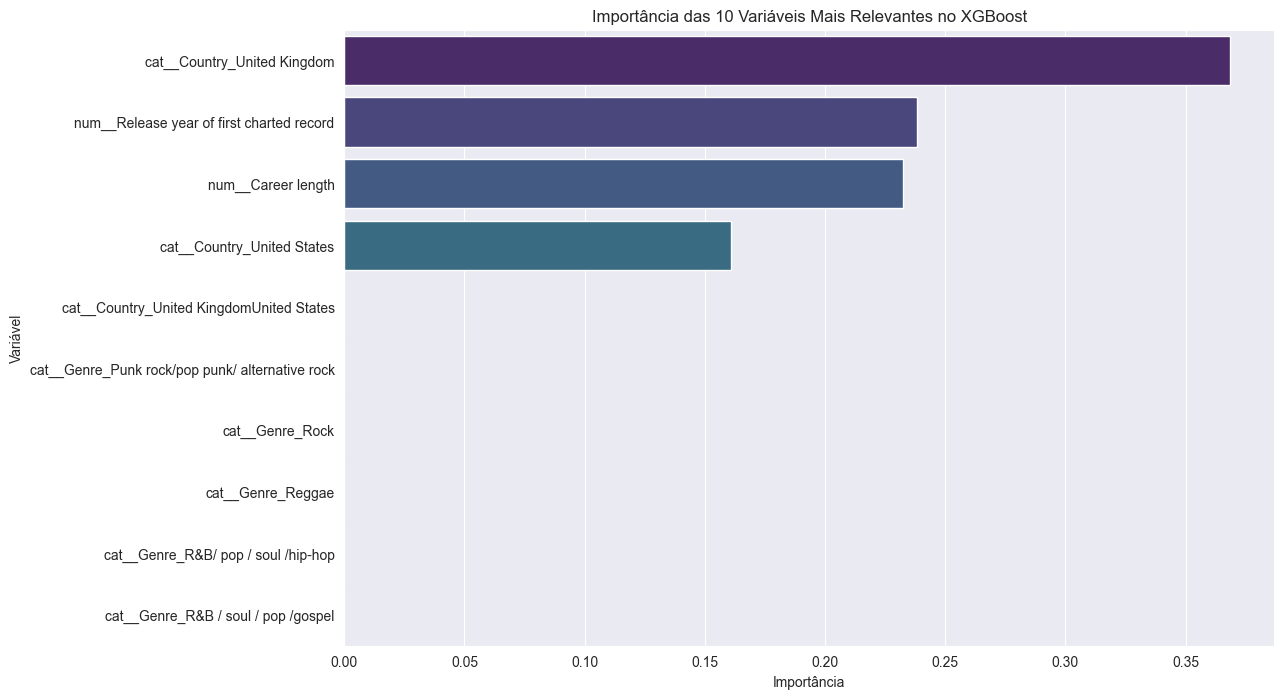

In [115]:
# Importância das variáveis no modelo XGBoost
import pandas as pd

importances = final_xgb.feature_importances_
feature_names = preprocessor.get_feature_names_out()
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(data=importance_df.head(10), x='Importance', y='Feature', palette='viridis')
plt.title("Importância das 10 Variáveis Mais Relevantes no XGBoost")
plt.xlabel("Importância")
plt.ylabel("Variável")
plt.show()


## Análise Visual do Dataset

### Gráfico de Dispersão 2D

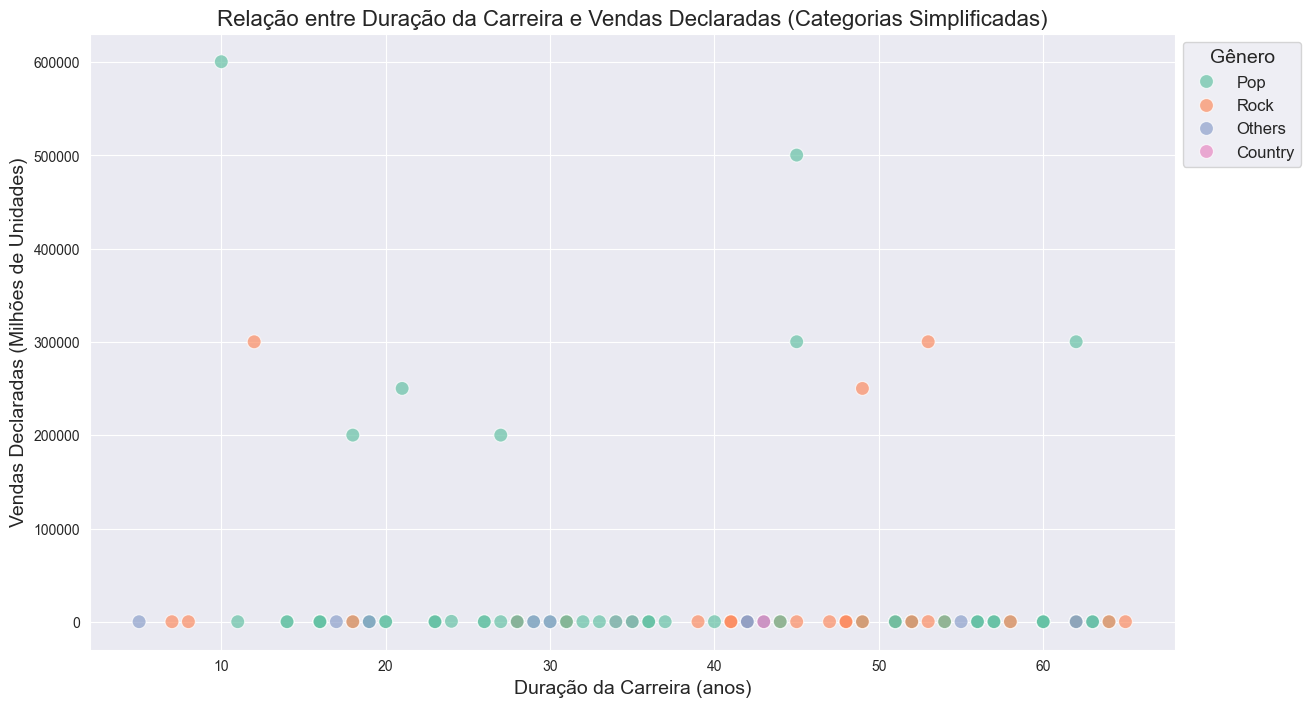

In [116]:
# Simplificando a coluna 'Genre' para categorias amplas
df['Simplified Genre'] = df['Genre'].apply(lambda x: 
    'Pop' if 'pop' in x.lower() else
    'Rock' if 'rock' in x.lower() else
    'Hip-Hop' if 'hip hop' in x.lower() else
    'Country' if 'country' in x.lower() else
    'Electronic' if 'electronic' in x.lower() else
    'Others'
)

# Gráfico de dispersão ajustado
plt.figure(figsize=(14, 8))
sns.scatterplot(
    data=df, 
    x='Career length', 
    y='Claimed sales', 
    hue='Simplified Genre', 
    palette='Set2', 
    alpha=0.7, 
    s=100
)
plt.title("Relação entre Duração da Carreira e Vendas Declaradas (Categorias Simplificadas)", fontsize=16)
plt.xlabel("Duração da Carreira (anos)", fontsize=14)
plt.ylabel("Vendas Declaradas (Milhões de Unidades)", fontsize=14)
plt.legend(title="Gênero", fontsize=12, title_fontsize=14, loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.show()


### Gráfico de Dispersão 3D



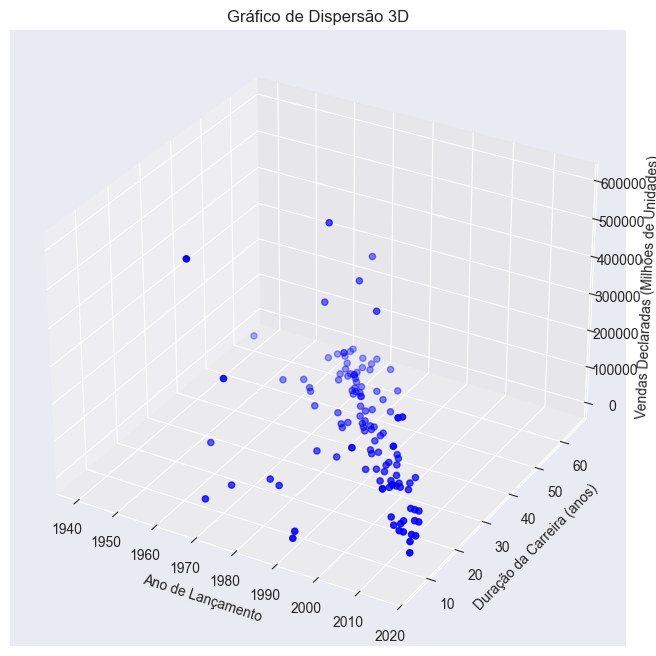

In [117]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Criando o gráfico 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plotando os dados
ax.scatter(df['Release year of first charted record'], df['Career length'], df['Claimed sales'], c='blue', marker='o')
ax.set_title("Gráfico de Dispersão 3D")
ax.set_xlabel("Ano de Lançamento")
ax.set_ylabel("Duração da Carreira (anos)")
ax.set_zlabel("Vendas Declaradas (Milhões de Unidades)")
plt.show()


### Gráfico de Barras para Vendas por Gênero



C:\Users\karin\AppData\Local\Temp\ipykernel_7668\3771400446.py:16: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




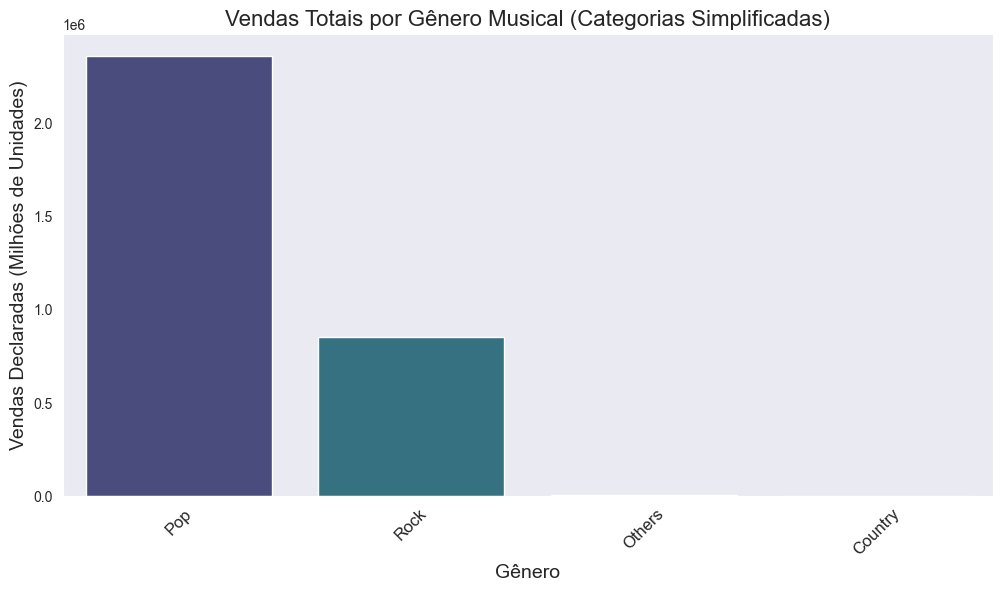

In [118]:
# Simplificando a coluna 'Genre' para categorias amplas
df['Simplified Genre'] = df['Genre'].apply(lambda x: 
    'Pop' if 'pop' in x.lower() else
    'Rock' if 'rock' in x.lower() else
    'Hip-Hop' if 'hip hop' in x.lower() else
    'Country' if 'country' in x.lower() else
    'Electronic' if 'electronic' in x.lower() else
    'Others'
)

# Agrupando por gênero simplificado e somando as vendas declaradas
genre_sales = df.groupby('Simplified Genre')['Claimed sales'].sum().sort_values(ascending=False)

# Plotando o gráfico de barras
plt.figure(figsize=(12, 6))
sns.barplot(x=genre_sales.index, y=genre_sales.values, palette='viridis')
plt.title("Vendas Totais por Gênero Musical (Categorias Simplificadas)", fontsize=16)
plt.xlabel("Gênero", fontsize=14)
plt.ylabel("Vendas Declaradas (Milhões de Unidades)", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.grid(axis='y')
plt.show()


### Gráfico 3D Animado com Plotly

In [119]:
import plotly.express as px
import pandas as pd

# Removendo dados nulos e ajustando a escala de vendas
df_clean = df.dropna(subset=['Claimed sales'])
df_clean['Claimed sales (Millions)'] = df_clean['Claimed sales'] / 1_000_000

# Simplificando os gêneros
df_clean['Simplified Genre'] = df_clean['Genre'].apply(lambda x: 
    'Pop' if 'pop' in x.lower() else
    'Rock' if 'rock' in x.lower() else
    'Hip-Hop' if 'hip hop' in x.lower() else
    'Country' if 'country' in x.lower() else
    'Electronic' if 'electronic' in x.lower() else
    'Others'
)

# Criando uma sequência completa de anos
min_year = df_clean['Release year of first charted record'].min()
max_year = df_clean['Release year of first charted record'].max()
all_years = pd.DataFrame({'Release year of first charted record': range(min_year, max_year + 1)})

# Mesclando os dados para preencher os anos ausentes
df_complete = pd.merge(all_years, df_clean, on='Release year of first charted record', how='left')
df_complete.fillna(0, inplace=True)  # Substituir valores nulos por zero

# Criando o gráfico 3D animado
fig = px.scatter_3d(
    df_complete,
    x='Release year of first charted record',
    y='Career length',
    z='Claimed sales (Millions)',
    color='Simplified Genre',
    size='Claimed sales (Millions)',
    hover_name='Artist name',
    hover_data={
        'Release year of first charted record': True,
        'Career length': True,
        'Claimed sales (Millions)': ':.2f'
    },
    animation_frame='Release year of first charted record',
    range_x=[min_year, max_year],
    range_y=[0, df_clean['Career length'].max() + 10],
    range_z=[0, df_clean['Claimed sales (Millions)'].max() + 50],
    title='Evolução Completa das Vendas de Artistas ao Longo dos Anos (Gráfico 3D Animado)',
    labels={
        'Release year of first charted record': 'Ano de Lançamento',
        'Career length': 'Duração da Carreira (anos)',
        'Claimed sales (Millions)': 'Vendas Declaradas (Milhões de Unidades)',
        'Simplified Genre': 'Gênero'
    }
)

# Ajustando o layout para melhorar a visualização
fig.update_layout(
    width=1400,  # Aumentando a largura
    height=800,  # Aumentando a altura
    scene=dict(
        xaxis_title='Ano de Lançamento',
        yaxis_title='Duração da Carreira (anos)',
        zaxis_title='Vendas Declaradas (Milhões de Unidades)',
        xaxis=dict(tickangle=45, title_font=dict(size=14), tickfont=dict(size=12)),
        yaxis=dict(title_font=dict(size=14), tickfont=dict(size=12)),
        zaxis=dict(title_font=dict(size=14), tickfont=dict(size=12)),
    ),
    margin=dict(l=100, r=100, b=100, t=100)  # Ajuste de margens para evitar cortes
)

# Ajustando a perspectiva da câmera
fig.update_layout(
    scene_camera=dict(
        eye=dict(x=1.5, y=1.8, z=1.5)  # Alterando a posição da câmera para melhor visualização
    )
)

# Configurando os botões de animação
fig.update_layout(
    updatemenus=[{
        "buttons": [
            {
                "label": "Play",
                "method": "animate",
                "args": [None, {"frame": {"duration": 800, "redraw": True}, "fromcurrent": True}]
            },
            {
                "label": "Pause",
                "method": "animate",
                "args": [[None], {"frame": {"duration": 0, "redraw": False}, "mode": "immediate"}]
            }
        ],
        "direction": "left",
        "pad": {"r": 10, "t": 87},
        "showactive": False,
        "type": "buttons"
    }]
)

# Ajustando o controle do slider
fig.update_layout(
    sliders=[{
        "active": 0,
        "yanchor": "top",
        "xanchor": "left",
        "currentvalue": {"font": {"size": 20}, "prefix": "Ano: ", "visible": True, "xanchor": "right"},
        "transition": {"duration": 300, "easing": "cubic-in-out"},
        "pad": {"b": 10},
        "len": 0.9,
        "x": 0.1,
        "y": 0,
        "steps": [
            {
                "args": [[str(year)], {"frame": {"duration": 300, "redraw": True}, "mode": "immediate"}],
                "label": str(year),
                "method": "animate"
            } for year in range(min_year, max_year + 1)
        ]
    }]
)

# Exibindo o gráfico
fig.show()


## Análises Avançadas

### Modelagem Preditiva:

Modelo de regressão linear para prever as vendas com base em variáveis como "Ano de Lançamento", "Duração da Carreira" e "Gênero".

In [121]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

X = df_clean[['Release year of first charted record', 'Career length']]
y = df_clean['Claimed sales (Millions)']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
print(f'R² Score: {model.score(X_test, y_test):.2f}')


R² Score: 0.08


## Clusterização (K-Means):

Agrupamento dos artistas em clusters com base nas vendas e duração da carreira para identificar perfis semelhantes.

In [123]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42)
df_clean['Cluster'] = kmeans.fit_predict(df_clean[['Career length', 'Claimed sales (Millions)']])
fig = px.scatter(df_clean, x='Career length', y='Claimed sales (Millions)', color='Cluster', title='Clusterização dos Artistas')
fig.show()


## Visualização dos Clusters
Gráfico para visualizar melhor a separação dos clusters

In [124]:
import plotly.express as px

fig = px.scatter(
    df_clean,
    x='Career length',
    y='Claimed sales (Millions)',
    color='Cluster',
    hover_name='Artist name',
    title='Clusterização dos Artistas por Duração da Carreira e Vendas Declaradas'
)
fig.show()


## Conclusão e Considerações Finais

Durante este estudo, exploramos um dataset detalhado sobre os artistas mais vendidos de todos os tempos, analisando diversos aspectos de suas carreiras e vendas. Aqui estão os principais pontos e insights obtidos:

## Resumo do Projeto
- Iniciamos o projeto com uma análise exploratória de dados (EDA) para entender melhor a distribuição dos dados, identificar gêneros musicais dominantes e observar a evolução das vendas ao longo do tempo.
- Utilizamos diversas técnicas de visualização para apresentar as tendências nos dados, incluindo gráficos 3D animados, histogramas e gráficos de linhas.
- Aplicamos técnicas de clusterização (K-Means) para identificar grupos distintos de artistas com base em variáveis como duração da carreira e vendas declaradas.

## Principais Insights

### Gêneros Populares e Tendências de Vendas
- Gêneros como **Pop** e **Rock** se destacaram como os mais vendidos, representando a maior parte das vendas declaradas. Isso sugere uma preferência clara do público por esses estilos musicais ao longo das décadas.
- Outros gêneros, como **Hip-Hop** e **Country**, também mostraram crescimento significativo, especialmente nas últimas décadas, refletindo mudanças nas tendências de consumo musical.

### Evolução das Vendas ao Longo do Tempo
- Observamos um aumento nas vendas agregadas de álbuns ao longo do tempo, especialmente nas décadas de 1980 e 1990, que coincidem com a era de ouro dos álbuns físicos.
- Após o ano 2000, houve uma estabilização e possível declínio nas vendas declaradas, possivelmente devido à transição para a era digital e o aumento dos serviços de streaming, que não estão completamente representados no dataset.

### Relação entre Duração da Carreira e Sucesso
- A análise revelou uma correlação clara entre a **duração da carreira** e o sucesso comercial dos artistas. Aqueles que mantêm carreiras mais longas tendem a acumular mais vendas, sugerindo que consistência e permanência na indústria são fatores-chave para alcançar o status de superstar.

### Clusterização dos Artistas
- A aplicação do algoritmo de K-Means permitiu identificar três perfis distintos de artistas:
  - **Cluster 0**: Artistas com vendas baixas e carreiras curtas, representando aqueles que tiveram menor impacto comercial.
  - **Cluster 1**: Artistas com vendas e carreiras moderadas, que obtiveram algum sucesso, mas não alcançaram o nível dos superstars.
  - **Cluster 2**: Os superstars, com vendas expressivas e carreiras longas, que representam os artistas mais bem-sucedidos do dataset.
